In [1]:
import gc
import os
import re
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import catboost as cb
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
%%time
train_df = pd.read_csv("../input/train_dataset.csv")
test_df = pd.read_csv("../input/test_dataset.csv")

CPU times: user 368 ms, sys: 44 ms, total: 412 ms
Wall time: 407 ms


In [3]:
train_df.shape, test_df.shape

((50000, 30), (50000, 29))

In [4]:
train_df.head()

,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,...,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,...,1,1,713,0,2740,7145,0,0,30,664
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,...,0,0,414,0,2731,44862,0,0,0,530
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,...,0,0,3391,0,0,4804,0,0,1,643
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,...,1,1,500,0,1931,3141,0,0,5,649
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,...,1,0,522,0,64,59,0,0,0,648


In [5]:
train_df = train_df.rename(columns={'用户编码':'id',
                         '信用分':'score',
                         '用户实名制是否通过核实':'is_real_name_checked',
 '用户年龄':'age_user',
 '是否大学生客户':'is_college_student',
 '是否黑名单客户':'is_black_list',
 '是否4G不健康客户':'is_4g_unhealthy',
 '用户网龄（月）':'network_age_month',
 '用户最近一次缴费距今时长（月）':'latest_month_payment',
 '缴费用户最近一次缴费金额（元）':'latest_fee_payment',
 '用户近6个月平均消费值（元）':'last_6_month_avg_consumption',
 '用户账单当月总费用（元）':'cur_month_sum_fee',
 '用户当月账户余额（元）':'cur_month_account_balance',
 '缴费用户当前是否欠费缴费':'is_paymentuser_arrears',
 '用户话费敏感度':'call_sensitivity',
 '当月通话交往圈人数':'cur_month_count_people_in_circle',
 '是否经常逛商场的人':'is_offten_shopping',
 '近三个月月均商场出现次数':'last_3_month_avg_count_shopping',
 '当月是否逛过福州仓山万达':'is_cur_month_WanDa_shopping',
 '当月是否到过福州山姆会员店':'is_cur_month_Sam_shopping',
 '当月是否看电影':'is_cur_month_moving',
 '当月是否景点游览':'is_cur_month_tourism',
 '当月是否体育场馆消费':'is_cur_month_gym_consumption',
 '当月网购类应用使用次数':'cur_month_count_online_shopping',
 '当月物流快递类应用使用次数':'cur_month_count_express_delivery',
 '当月金融理财类应用使用总次数':'cur_month_count_finantial_management',
 '当月视频播放类应用使用次数':'cur_month_count_video_play',
 '当月飞机类应用使用次数':'cur_month_count_airplane',
 '当月火车类应用使用次数':'cur_month_count_train',
 '当月旅游资讯类应用使用次数':'cur_month_count_news_tourism'})

In [6]:
test_df = test_df.rename(columns={'用户编码':'id',
                         '用户实名制是否通过核实':'is_real_name_checked',
 '用户年龄':'age_user',
 '是否大学生客户':'is_college_student',
 '是否黑名单客户':'is_black_list',
 '是否4G不健康客户':'is_4g_unhealthy',
 '用户网龄（月）':'network_age_month',
 '用户最近一次缴费距今时长（月）':'latest_month_payment',
 '缴费用户最近一次缴费金额（元）':'latest_fee_payment',
 '用户近6个月平均消费值（元）':'last_6_month_avg_consumption',
 '用户账单当月总费用（元）':'cur_month_sum_fee',
 '用户当月账户余额（元）':'cur_month_account_balance',
 '缴费用户当前是否欠费缴费':'is_paymentuser_arrears',
 '用户话费敏感度':'call_sensitivity',
 '当月通话交往圈人数':'cur_month_count_people_in_circle',
 '是否经常逛商场的人':'is_offten_shopping',
 '近三个月月均商场出现次数':'last_3_month_avg_count_shopping',
 '当月是否逛过福州仓山万达':'is_cur_month_WanDa_shopping',
 '当月是否到过福州山姆会员店':'is_cur_month_Sam_shopping',
 '当月是否看电影':'is_cur_month_moving',
 '当月是否景点游览':'is_cur_month_tourism',
 '当月是否体育场馆消费':'is_cur_month_gym_consumption',
 '当月网购类应用使用次数':'cur_month_count_online_shopping',
 '当月物流快递类应用使用次数':'cur_month_count_express_delivery',
 '当月金融理财类应用使用总次数':'cur_month_count_finantial_management',
 '当月视频播放类应用使用次数':'cur_month_count_video_play',
 '当月飞机类应用使用次数':'cur_month_count_airplane',
 '当月火车类应用使用次数':'cur_month_count_train',
 '当月旅游资讯类应用使用次数':'cur_month_count_news_tourism'})

In [7]:
train_drop = train_df.copy()

In [8]:
test_drop = test_df.copy()

In [9]:
train_drop.head()

,id,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,...,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism,score
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,...,1,1,713,0,2740,7145,0,0,30,664
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,...,0,0,414,0,2731,44862,0,0,0,530
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,...,0,0,3391,0,0,4804,0,0,1,643
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,...,1,1,500,0,1931,3141,0,0,5,649
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,...,1,0,522,0,64,59,0,0,0,648


In [10]:
train_drop.drop(['id','score' ],axis=1, inplace=True)
test_drop.drop(['id'],axis=1, inplace=True)

In [11]:
features = train_drop.columns.values.tolist()

In [12]:
features

['is_real_name_checked',
 'age_user',
 'is_college_student',
 'is_black_list',
 'is_4g_unhealthy',
 'network_age_month',
 'latest_month_payment',
 'latest_fee_payment',
 'last_6_month_avg_consumption',
 'cur_month_sum_fee',
 'cur_month_account_balance',
 'is_paymentuser_arrears',
 'call_sensitivity',
 'cur_month_count_people_in_circle',
 'is_offten_shopping',
 'last_3_month_avg_count_shopping',
 'is_cur_month_WanDa_shopping',
 'is_cur_month_Sam_shopping',
 'is_cur_month_moving',
 'is_cur_month_tourism',
 'is_cur_month_gym_consumption',
 'cur_month_count_online_shopping',
 'cur_month_count_express_delivery',
 'cur_month_count_finantial_management',
 'cur_month_count_video_play',
 'cur_month_count_airplane',
 'cur_month_count_train',
 'cur_month_count_news_tourism']

In [13]:
numerical_features = [c for c in features if 'is_' not in c]

In [14]:
cat_features = [c for c in features if 'is_' in c]

In [15]:
numerical_features, cat_features

(['age_user',
  'network_age_month',
  'latest_month_payment',
  'latest_fee_payment',
  'last_6_month_avg_consumption',
  'cur_month_sum_fee',
  'cur_month_account_balance',
  'call_sensitivity',
  'cur_month_count_people_in_circle',
  'last_3_month_avg_count_shopping',
  'cur_month_count_online_shopping',
  'cur_month_count_express_delivery',
  'cur_month_count_finantial_management',
  'cur_month_count_video_play',
  'cur_month_count_airplane',
  'cur_month_count_train',
  'cur_month_count_news_tourism'],
 ['is_real_name_checked',
  'is_college_student',
  'is_black_list',
  'is_4g_unhealthy',
  'is_paymentuser_arrears',
  'is_offten_shopping',
  'is_cur_month_WanDa_shopping',
  'is_cur_month_Sam_shopping',
  'is_cur_month_moving',
  'is_cur_month_tourism',
  'is_cur_month_gym_consumption'])

In [16]:
len(features)

28

In [17]:
train_df['call_sensitivity'].describe()

count    50000.000000
mean         3.351920
std          1.241202
min          0.000000
25%          2.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: call_sensitivity, dtype: float64

In [18]:
train_df['latest_fee_payment'].describe()

count    50000.000000
mean        53.415929
std         61.812022
min          0.000000
25%          0.000000
50%         49.900000
75%         99.800000
max        998.000000
Name: latest_fee_payment, dtype: float64

In [19]:
train_df['last_6_month_avg_consumption'].describe()

count    50000.000000
mean        98.732081
std         60.757758
min          0.000000
25%         54.180000
50%         89.320000
75%        131.160000
max        840.570000
Name: last_6_month_avg_consumption, dtype: float64

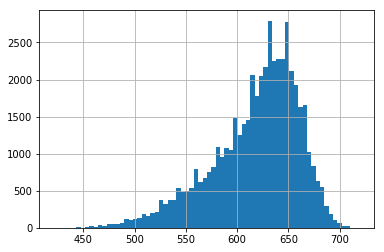

In [20]:
train_df['score'].hist(bins=70)

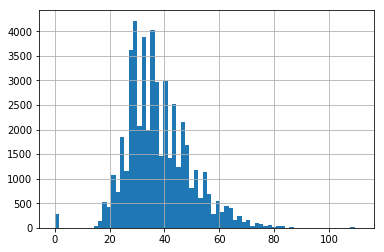

In [21]:
train_df['age_user'].hist(bins=70)

290名年龄为0的用户，需处理

In [22]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [23]:
# %%time
missing_data(train_df)

,id,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,...,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism,score
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,int64,int64,int64,int64,int64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [24]:
missing_data(test_df)

,id,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,...,is_cur_month_moving,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,int64,int64,int64,int64,int64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [25]:
train_df[(train_df['age_user'].isnull()) & (train_df['is_college_student'] == 0)]

,id,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,...,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism,score


In [26]:
%%time
missing_data(test_df)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 145 ms


,id,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,...,is_cur_month_moving,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,int64,int64,int64,int64,int64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [27]:
%%time
train_df.describe()

CPU times: user 220 ms, sys: 8 ms, total: 228 ms
Wall time: 226 ms


,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,cur_month_sum_fee,...,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism,score
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.99022,37.883440,0.003720,0.048800,0.088580,96.448680,0.700100,53.415929,98.732081,99.575130,...,0.47442,0.37412,1148.815260,1.197840,971.50308,3.366519e+03,0.704420,0.553340,19.117120,618.053060
std,0.09841,11.613239,0.060879,0.215452,0.284139,59.176593,0.458218,61.812022,60.757758,65.327335,...,0.49935,0.48390,3992.957952,44.469584,3006.16776,1.151006e+04,28.721302,7.735913,170.074772,42.443022
min,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,422.000000
25%,1.00000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.180000,52.675000,...,0.00000,0.00000,18.000000,0.000000,6.00000,1.000000e+01,0.000000,0.000000,0.000000,594.000000
50%,1.00000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,89.320000,89.620000,...,0.00000,0.00000,250.000000,0.000000,267.00000,3.350000e+02,0.000000,0.000000,0.000000,627.000000
75%,1.00000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,131.160000,133.945000,...,1.00000,1.00000,932.000000,0.000000,1147.25000,2.423250e+03,0.000000,0.000000,4.000000,649.000000
max,1.00000,111.000000,1.000000,1.000000,1.000000,288.000000,1.000000,998.000000,840.570000,1164.290000,...,1.00000,1.00000,234336.000000,8235.000000,496238.00000,1.382227e+06,5856.000000,474.000000,13965.000000,719.000000


In [28]:
%time
test_df.describe()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,cur_month_sum_fee,...,is_cur_month_moving,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000
mean,0.992260,37.932380,0.003520,0.048200,0.088800,96.094480,0.702740,54.027936,99.234402,99.842912,...,0.245320,0.476500,0.375340,1173.46996,0.853880,979.229100,3406.12244,0.595100,0.57584,19.672180
std,0.087637,11.636829,0.059226,0.214191,0.284458,59.048962,0.457057,62.614124,61.245686,65.301379,...,0.430281,0.499452,0.484215,4586.71334,28.848873,2924.008879,9919.40536,13.025441,8.20404,408.041808
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
25%,1.000000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.450000,53.200000,...,0.000000,0.000000,0.000000,17.00000,0.000000,5.000000,10.00000,0.000000,0.00000,0.000000
50%,1.000000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,90.000000,90.000000,...,0.000000,0.000000,0.000000,246.00000,0.000000,263.000000,333.00000,0.000000,0.00000,0.000000
75%,1.000000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,132.000000,135.235000,...,0.000000,1.000000,1.000000,935.00000,0.000000,1144.000000,2455.00000,0.000000,0.00000,4.000000
max,1.000000,108.000000,1.000000,1.000000,1.000000,288.000000,1.000000,1000.000000,1792.740000,2117.010000,...,1.000000,1.000000,1.000000,417536.00000,5462.000000,329767.000000,295210.00000,1645.000000,775.00000,87681.000000


In [29]:
test_feature = features[:15]

In [30]:
test_feature2 = features[15:]

In [31]:
test_feature

['is_real_name_checked',
 'age_user',
 'is_college_student',
 'is_black_list',
 'is_4g_unhealthy',
 'network_age_month',
 'latest_month_payment',
 'latest_fee_payment',
 'last_6_month_avg_consumption',
 'cur_month_sum_fee',
 'cur_month_account_balance',
 'is_paymentuser_arrears',
 'call_sensitivity',
 'cur_month_count_people_in_circle',
 'is_offten_shopping']

In [26]:
test_feature2

['last_3_month_avg_count_shopping',
 'is_cur_month_WanDa_shopping',
 'is_cur_month_Sam_shopping',
 'is_cur_month_moving',
 'is_cur_month_tourism',
 'is_cur_month_gym_consumption',
 'cur_month_count_online_shopping',
 'cur_month_count_express_delivery',
 'cur_month_count_finantial_management',
 'cur_month_count_video_play',
 'cur_month_count_airplane',
 'cur_month_count_train',
 'cur_month_count_news_tourism']

In [27]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

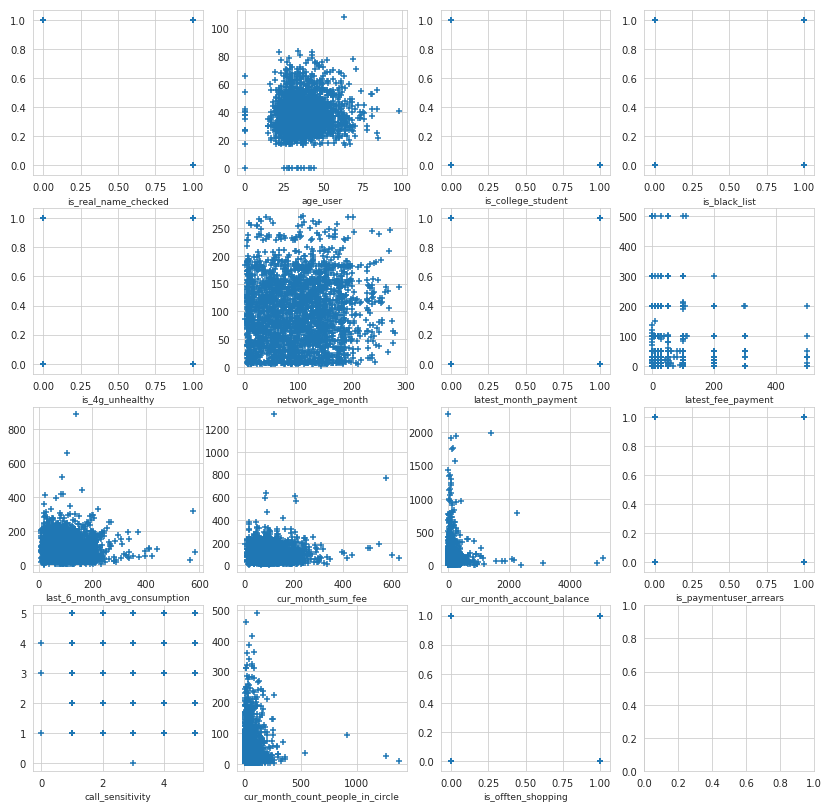

In [28]:
plot_feature_scatter(train_df[::20],test_df[::20], test_feature)

<Figure size 432x288 with 0 Axes>

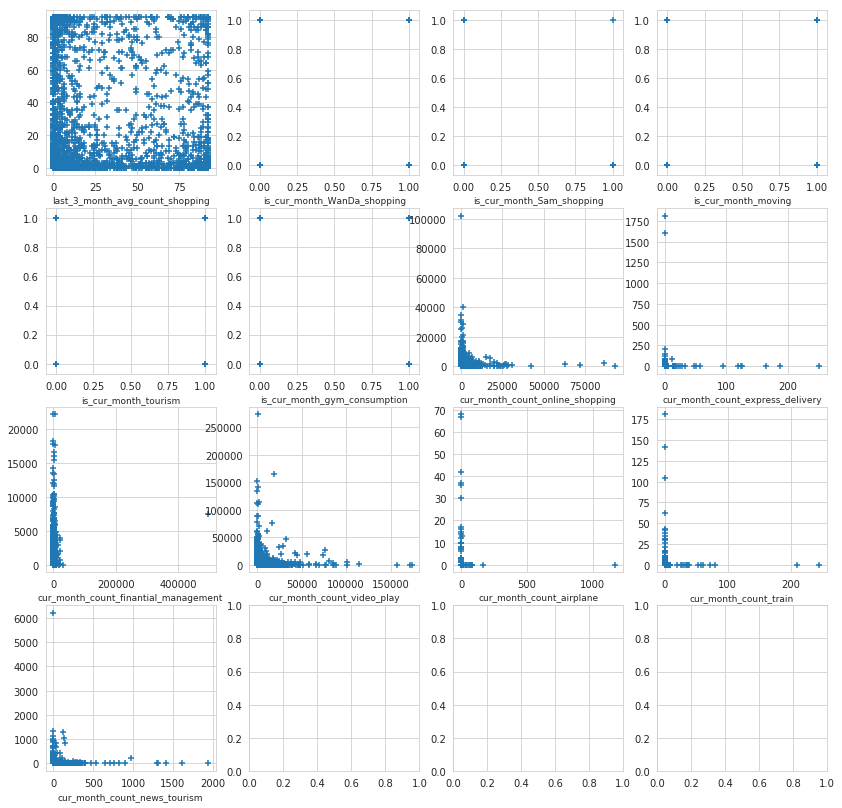

In [29]:
plot_feature_scatter(train_df[::20],test_df[::20], test_feature2)

In [30]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,6,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(3,6,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

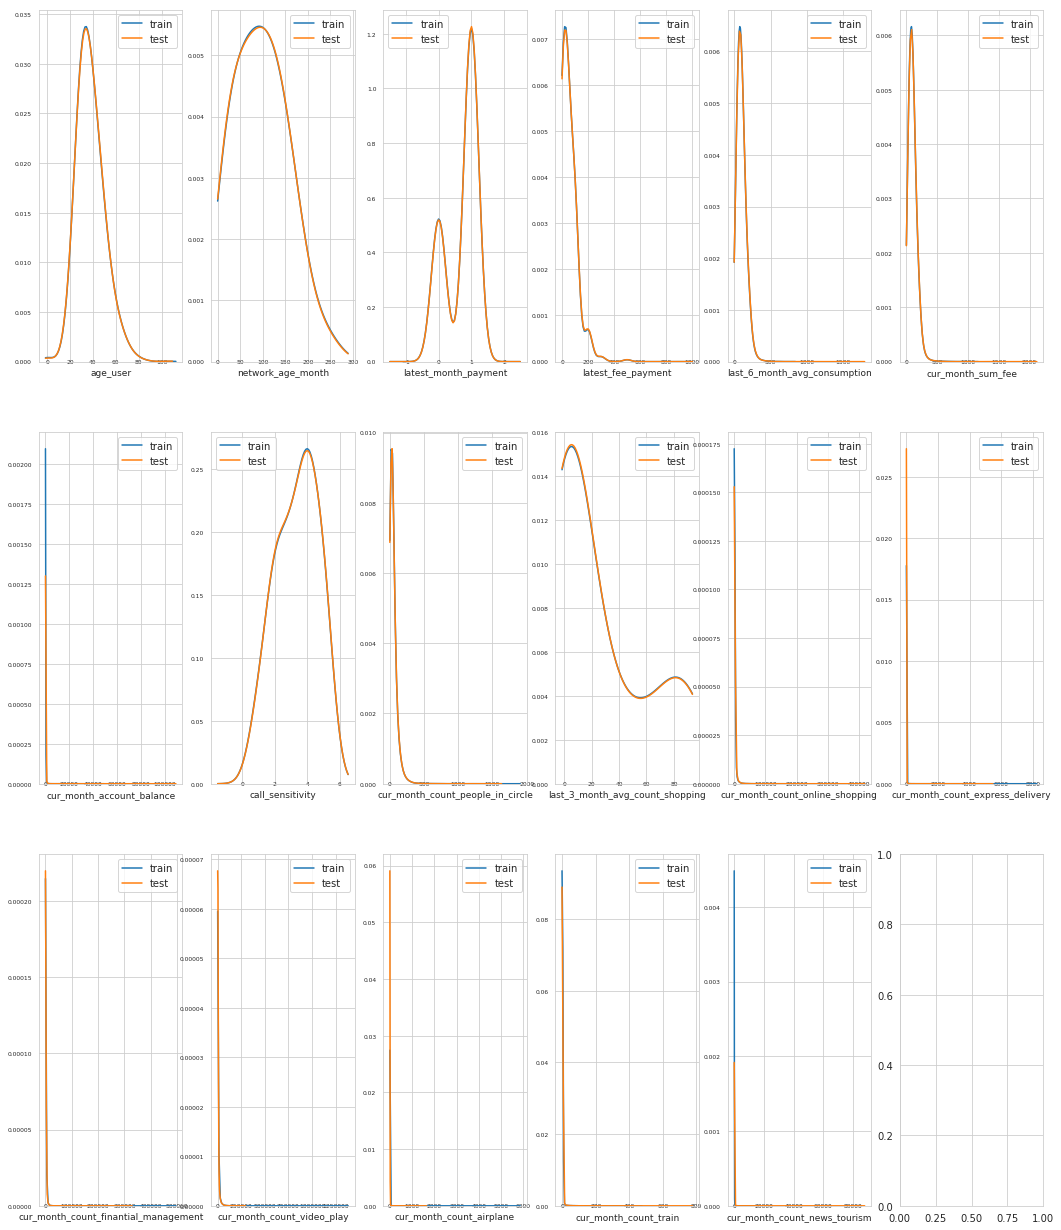

In [31]:
plot_feature_distribution(train_df, test_df, 'train', 'test', numerical_features)

## <a id='36'>Duplicate values</a>  

Let's now check how many duplicate values exists per columns.

In [32]:
%%time
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 140 ms, sys: 16 ms, total: 156 ms
Wall time: 153 ms


Let's show the top 15 max of duplicate values per train set.

In [33]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(14))

,2,0,25,22,17,16,3,26,11,4,18,6,14,20
Feature,is_college_student,is_real_name_checked,cur_month_count_airplane,cur_month_count_express_delivery,is_cur_month_Sam_shopping,is_cur_month_WanDa_shopping,is_black_list,cur_month_count_train,is_paymentuser_arrears,is_4g_unhealthy,is_cur_month_moving,latest_month_payment,is_offten_shopping,is_cur_month_gym_consumption
Max duplicates,49814,49511,49314,49279,48644,48065,47560,47530,47373,45571,37886,35005,33525,31294
Value,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).tail(14))

,27,19,12,7,15,23,24,21,10,1,9,13,5,8
Feature,cur_month_count_news_tourism,is_cur_month_tourism,call_sensitivity,latest_fee_payment,last_3_month_avg_count_shopping,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_online_shopping,cur_month_account_balance,age_user,cur_month_sum_fee,cur_month_count_people_in_circle,network_age_month,last_6_month_avg_consumption
Max duplicates,30590,26279,14994,14755,10428,9141,8670,7986,4017,2168,1124,901,610,198
Value,0,0,4,0,0,0,0,0,50,29,18,11,5,18


Let's see also the top 15 number of duplicates values per test set.

In [35]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(14))

,2,0,25,22,17,16,3,26,11,4,18,6,14,20
Feature,is_college_student,is_real_name_checked,cur_month_count_airplane,cur_month_count_express_delivery,is_cur_month_Sam_shopping,is_cur_month_WanDa_shopping,is_black_list,cur_month_count_train,is_paymentuser_arrears,is_4g_unhealthy,is_cur_month_moving,latest_month_payment,is_offten_shopping,is_cur_month_gym_consumption
Max duplicates,49824,49613,49318,49255,48651,48012,47590,47477,47444,45560,37734,35137,33403,31233
Value,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).tail(14))

,27,19,12,7,15,23,24,21,10,1,9,13,5,8
Feature,cur_month_count_news_tourism,is_cur_month_tourism,call_sensitivity,latest_fee_payment,last_3_month_avg_count_shopping,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_online_shopping,cur_month_account_balance,age_user,cur_month_sum_fee,cur_month_count_people_in_circle,network_age_month,last_6_month_avg_consumption
Max duplicates,30616,26175,14844,14602,10327,9222,8685,7951,3992,2158,1150,885,670,212
Value,0,0,4,0,0,0,0,0,50,36,18,16,5,18


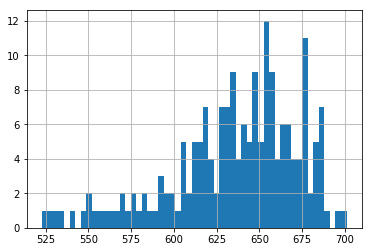

In [10]:
train_df[train_df['is_college_student'] == 1]['score'].hist(bins=55)

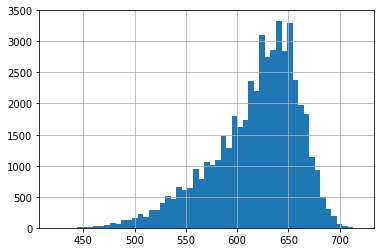

In [11]:
train_df[train_df['is_college_student'] == 0]['score'].hist(bins=55)

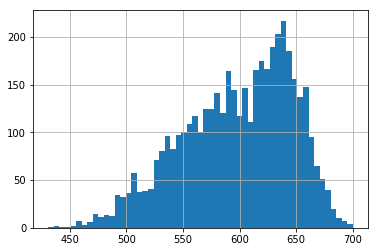

In [12]:
train_df[train_df['is_4g_unhealthy'] == 1]['score'].hist(bins=55)

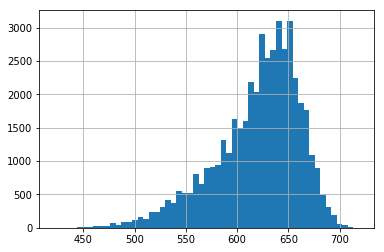

In [13]:
train_df[train_df['is_4g_unhealthy'] == 0]['score'].hist(bins=55)

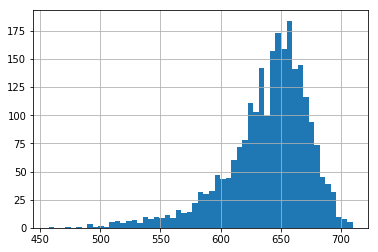

In [14]:
train_df[train_df['is_black_list'] == 1]['score'].hist(bins=55)

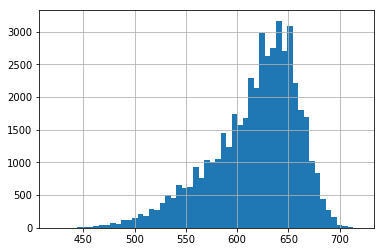

In [15]:
train_df[train_df['is_black_list'] == 0]['score'].hist(bins=55)

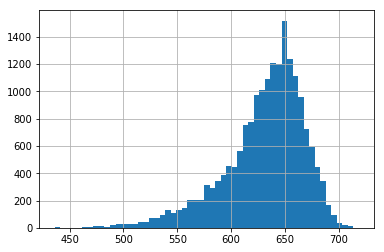

In [16]:
train_df[train_df['is_cur_month_gym_consumption'] == 1]['score'].hist(bins=55)

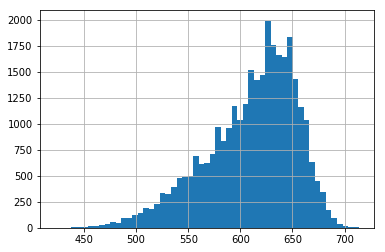

In [17]:
train_df[train_df['is_cur_month_gym_consumption'] == 0]['score'].hist(bins=55)

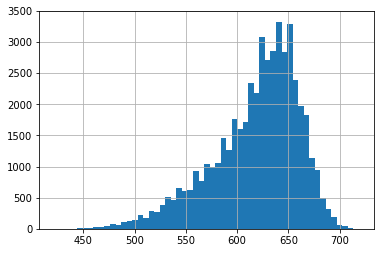

In [18]:
train_df[train_df['is_real_name_checked'] == 1]['score'].hist(bins=55)

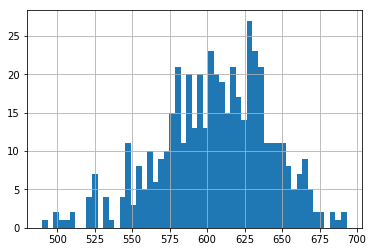

In [30]:
train_df[(train_df['is_real_name_checked'] == 0)]['score'].hist(bins=55)

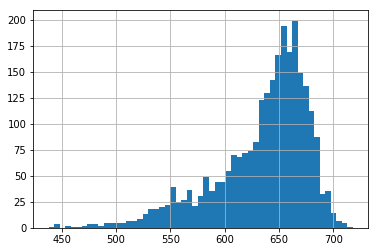

In [36]:
train_df[(train_df['is_paymentuser_arrears'] == 1)]['score'].hist(bins=55)

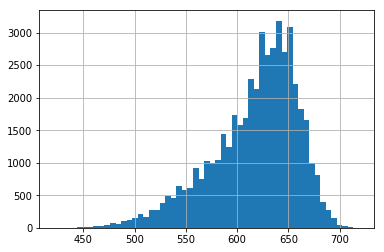

In [21]:
train_df[train_df['is_paymentuser_arrears'] == 0]['score'].hist(bins=55)

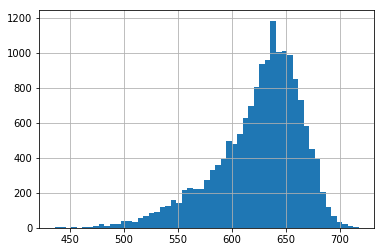

In [22]:
train_df[train_df['is_offten_shopping'] == 1]['score'].hist(bins=55)

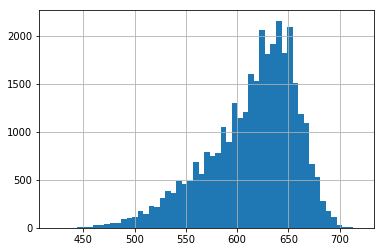

In [23]:
train_df[train_df['is_offten_shopping'] == 0]['score'].hist(bins=55)

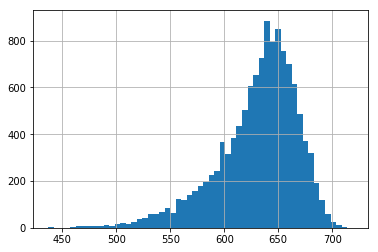

In [24]:
train_df[train_df['is_cur_month_moving'] == 1]['score'].hist(bins=55)

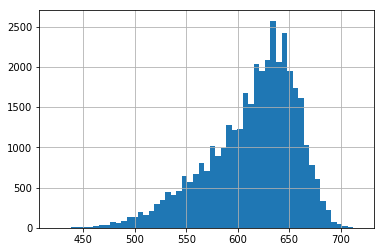

In [25]:
train_df[train_df['is_cur_month_moving'] == 0]['score'].hist(bins=55)

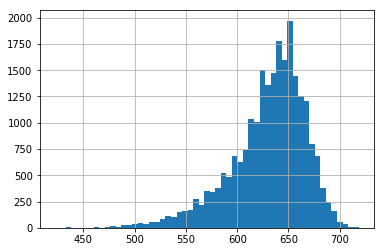

In [26]:
train_df[train_df['is_cur_month_tourism'] == 1]['score'].hist(bins=55)

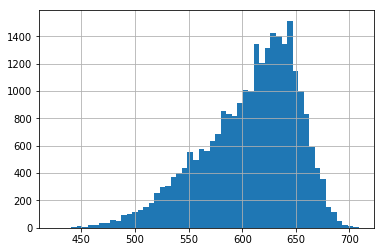

In [27]:
train_df[train_df['is_cur_month_tourism'] == 0]['score'].hist(bins=55)

In [39]:
train_df[train_df['call_sensitivity'] == 0]

,id,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,...,is_cur_month_tourism,is_cur_month_gym_consumption,cur_month_count_online_shopping,cur_month_count_express_delivery,cur_month_count_finantial_management,cur_month_count_video_play,cur_month_count_airplane,cur_month_count_train,cur_month_count_news_tourism,score
390,93a94c3d61c2470880f070e4b8a3eb84,1,45,0,0,1,58,1,29.94,166.34,...,1,1,9,0,2,16,0,0,0,645
994,af9e8fc9dd524463b0e5d00a45fc2143,1,32,0,0,0,100,0,0.00,16.59,...,0,0,0,0,0,0,0,0,0,526
1005,bfea139bd37441ca9e5a2129e677cdda,1,54,0,0,1,55,0,0.00,128.65,...,0,0,0,0,0,0,0,0,0,652
4614,91aa55754f774fe2bb1dbe03312b36c4,1,42,0,0,1,28,1,29.94,46.73,...,1,0,1,0,0,0,0,0,0,531
13134,a3520c7cdf3241358600ecfc475a3e0c,1,42,0,0,0,10,1,29.94,25.85,...,0,0,2,0,10,2,0,0,0,528
16086,ee73e19034004f5c82920e0e645a9341,1,26,0,0,0,1,0,102.96,33.22,...,0,0,0,0,19,3,0,0,0,625
23706,c53cf9a80d974d4ca3e2a64e7795b8ef,1,52,0,0,1,48,0,0.00,29.49,...,0,0,0,0,0,0,0,0,0,615
28760,5be81bcfca6049d79b1a277e12d829dc,1,32,0,0,1,117,1,199.60,140.30,...,1,1,64,0,58,21953,0,0,6,639
31420,a5dd2e0fe6b04946afb9cbb973bbea34,1,34,0,0,0,6,1,49.90,98.52,...,0,0,25,0,0,340,0,0,0,530
33360,11bf1944ea3b47ba9e357ade6413c58f,1,39,0,0,0,10,1,29.94,90.59,...,0,0,3,0,409,89,0,0,0,556


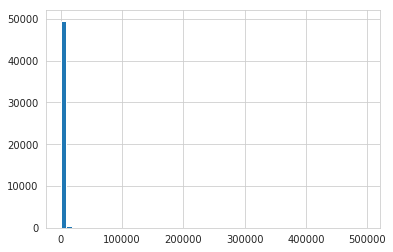

# <a id='4'>Feature engineering</a>  

This section is under construction.  

Let's calculate for starting few aggregated values for the existing features.

In [32]:
train_df['age_user'].mode()

0    29
dtype: int64

In [33]:
df_test = train_df.copy()

In [34]:
def map_age(x):
    if x<=17:
        return 1
    elif x<=30:
        return 2
    elif x<=35:
        return 3
    elif x<=45:
        return 4
    else:
        return 5

In [35]:
%%time
for df in [test_df, train_df]:
#     年龄异常值标记
    df.loc[df['age_user'] == 0, 'age_outlier'] = 1
    df.loc[df['age_user'] != 0, 'age_outlier'] = 0
    df.loc[df['age_user'] > 100, 'age_outlier'] = 2
    
    df.loc[df['age_user'] == 0, 'age_user'] = df['age_user'].mode()
    df.loc[df['call_sensitivity'] == 0, 'call_sensitivity'] = df['call_sensitivity'].mode()
    
#     df.loc[df['last_6_month_avg_consumption'] == 0, 'last_6_month_avg_consumption'] = df['last_6_month_avg_consumption'].mode()
#     df.loc[df['latest_fee_payment'] == 0, 'latest_fee_payment'] = df['latest_fee_payment'].mode()
    
    
# #     年龄分箱 lgb不用
#     df['age_user'] = df['age_user'].map(lambda x:map_age(x))
#     入网年龄
    df['network_enter_age'] = df['age_user'] - df['network_age_month']/12
#     是否去过高档商场
    df['is_enter_expensive_mall'] = df['is_cur_month_WanDa_shopping'] * df['is_cur_month_Sam_shopping']
#     交通类应用使用次数
    df['cur_month_count_travel'] = df['cur_month_count_airplane'] + df['cur_month_count_train']
#     缴费方式
    df['payment_way'] = 0
    df['payment_way'][(df['latest_fee_payment']%10 == 0) & (df['latest_fee_payment'] != 0)] = 1
#     消费稳定性---当月话费使用率
    df['consumption_stability'] = df['cur_month_sum_fee'] / (df['cur_month_account_balance'] + 1)
#   缴费稳定性
    df['payment_stability'] = df['cur_month_sum_fee'] / (df['last_6_month_avg_consumption'] + 1)
#     缴费金额与当月账单差值
    df['difference_latest_payment_and_sum_fee'] = df['latest_fee_payment'] - df['cur_month_sum_fee']
# 最近一次缴费与平均消费差值
    df['difference_payment_and_avg_consumption'] = df['latest_fee_payment'] - df['last_6_month_avg_consumption']
# 当月账单与平均消费差值
    df['difference_sum_fee_and_avg_consumption'] = df['cur_month_sum_fee'] - df['last_6_month_avg_consumption']
#     6个月平均占总费用
    df['ratio_last_6_month_/_sum_fee'] = df['last_6_month_avg_consumption'] / (df['cur_month_sum_fee']+1)
#     6个月平均占话费余额
#     df['last_6_month_ratio_balance'] = df['last_6_month_avg_consumption'] / (df['cur_month_account_balance']+1)


CPU times: user 236 ms, sys: 68 ms, total: 304 ms
Wall time: 299 ms


In [36]:
train_df['latest_fee_payment'].describe()

count    50000.000000
mean        53.415929
std         61.812022
min          0.000000
25%          0.000000
50%         49.900000
75%         99.800000
max        998.000000
Name: latest_fee_payment, dtype: float64

In [37]:
test_df['last_6_month_avg_consumption'].describe()

count    50000.000000
mean        99.234402
std         61.245686
min          0.000000
25%         54.450000
50%         90.000000
75%        132.000000
max       1792.740000
Name: last_6_month_avg_consumption, dtype: float64

In [38]:
def base_process(data):
    transform_value_feature = ['age_user', 'network_age_month', 'cur_month_count_people_in_circle', 'last_3_month_avg_count_shopping', 'cur_month_count_online_shopping','cur_month_count_express_delivery','cur_month_count_finantial_management','cur_month_count_video_play','cur_month_count_airplane','cur_month_count_train','cur_month_count_news_tourism','cur_month_count_travel']
    user_feature = ['cur_month_count_people_in_circle','latest_fee_payment','cur_month_sum_fee', 'cur_month_account_balance', 'last_6_month_avg_consumption']
    log_feature = ['last_3_month_avg_count_shopping', 'cur_month_count_online_shopping','cur_month_count_express_delivery','cur_month_count_finantial_management','cur_month_count_video_play','cur_month_count_airplane','cur_month_count_train','cur_month_count_news_tourism']
    
# #     处理离散点
#     for col in transform_value_feature + log_feature:
# #         取出最高99.9%
#         ulimit = np.percentile(train_df[col].values, 99.9)
# #         取出最低0.1%
#         llimit = np.percentile(train_df[col].values, 0.1)
#         train_df.loc[train_df[col]>ulimit, col] = ulimit
#         train_df.loc[train_df[col]<ulimit, col] = llimit
#         
    for col in user_feature+log_feature:
        data[col] = data[col].map(lambda x:np.sign(x)*np.log1p(np.abs(x)))
#     
    return data

In [39]:
train_df = base_process(train_df)
test_df = base_process(test_df)

In [40]:
train_df[train_df.columns[30:]].head()

,age_outlier,network_enter_age,is_enter_expensive_mall,cur_month_count_travel,payment_way,consumption_stability,payment_stability,difference_latest_payment_and_sum_fee,difference_payment_and_avg_consumption,difference_sum_fee_and_avg_consumption,ratio_last_6_month_/_sum_fee
0,0.0,28.500000,0,0,0,0.879558,0.965668,-59.40,-64.06,-4.66,1.022846
1,0.0,17.583333,0,0,0,1.307207,0.940498,-115.16,-123.34,-8.18,1.049144
2,0.0,34.916667,0,0,0,1.692958,1.086406,-70.30,-59.74,10.56,0.904620
3,0.0,35.500000,0,0,0,1.839780,1.781632,-67.62,6.83,74.45,0.552013
4,0.0,33.666667,0,0,0,1.246914,1.046958,-51.10,-45.57,5.53,0.935980


In [41]:
test_df[train_df.columns[30:]].head()

,age_outlier,network_enter_age,is_enter_expensive_mall,cur_month_count_travel,payment_way,consumption_stability,payment_stability,difference_latest_payment_and_sum_fee,difference_payment_and_avg_consumption,difference_sum_fee_and_avg_consumption,ratio_last_6_month_/_sum_fee
0,0.0,28.166667,0,0,0,0.263770,0.714306,49.42,30.27,-19.15,1.353250
1,0.0,63.000000,0,0,0,1.621905,2.452124,-34.06,-12.89,21.17,0.367655
2,0.0,15.250000,0,0,0,1.413967,1.051503,-171.09,-161.71,9.38,0.939683
3,0.0,30.583333,0,0,0,1.009050,0.967042,-223.00,-229.60,-6.60,1.025000
4,0.0,31.250000,0,0,0,2.031373,0.973501,-3.80,-5.62,-1.82,1.007839


# <a id='5'>Model</a>  

From the train columns list, we drop the ID and target to form the features list.

In [42]:
target = train_df['score']
train_df.drop(['id', 'score'], axis=1, inplace=True)

In [43]:
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events

In [44]:
train_df.head()

,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,cur_month_sum_fee,...,network_enter_age,is_enter_expensive_mall,cur_month_count_travel,payment_way,consumption_stability,payment_stability,difference_latest_payment_and_sum_fee,difference_payment_and_avg_consumption,difference_sum_fee_and_avg_consumption,ratio_last_6_month_/_sum_fee
0,1,44.0,0,0,0,186,1,4.613138,5.105097,5.076423,...,28.500000,0,0,0,0.879558,0.965668,-59.40,-64.06,-4.66,1.022846
1,1,18.0,0,0,1,5,1,3.432050,5.038769,4.984291,...,17.583333,0,0,0,1.307207,0.940498,-115.16,-123.34,-8.18,1.049144
2,1,47.0,0,0,0,145,1,3.929863,4.706282,4.797442,...,34.916667,0,0,0,1.692958,1.086406,-70.30,-59.74,10.56,0.904620
3,1,55.0,0,0,0,234,1,4.613138,4.542976,5.126461,...,35.500000,0,0,0,1.839780,1.781632,-67.62,6.83,74.45,0.552013
4,1,40.0,0,0,0,76,1,3.929863,4.569232,4.624973,...,33.666667,0,0,0,1.246914,1.046958,-51.10,-45.57,5.53,0.935980


In [45]:
X = train_df

In [46]:
X.head()

,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,cur_month_sum_fee,...,network_enter_age,is_enter_expensive_mall,cur_month_count_travel,payment_way,consumption_stability,payment_stability,difference_latest_payment_and_sum_fee,difference_payment_and_avg_consumption,difference_sum_fee_and_avg_consumption,ratio_last_6_month_/_sum_fee
0,1,44.0,0,0,0,186,1,4.613138,5.105097,5.076423,...,28.500000,0,0,0,0.879558,0.965668,-59.40,-64.06,-4.66,1.022846
1,1,18.0,0,0,1,5,1,3.432050,5.038769,4.984291,...,17.583333,0,0,0,1.307207,0.940498,-115.16,-123.34,-8.18,1.049144
2,1,47.0,0,0,0,145,1,3.929863,4.706282,4.797442,...,34.916667,0,0,0,1.692958,1.086406,-70.30,-59.74,10.56,0.904620
3,1,55.0,0,0,0,234,1,4.613138,4.542976,5.126461,...,35.500000,0,0,0,1.839780,1.781632,-67.62,6.83,74.45,0.552013
4,1,40.0,0,0,0,76,1,3.929863,4.569232,4.624973,...,33.666667,0,0,0,1.246914,1.046958,-51.10,-45.57,5.53,0.935980


In [47]:
y = target

In [34]:
y.head()

0    664
1    530
2    643
3    649
4    648
Name: score, dtype: int64

In [31]:
testlist = [15.1, 14.8, 16.9]

In [30]:
np.divide(1,(np.add(testlist,1)))

array([0.0621118 , 0.06329114, 0.05586592])

In [31]:
categorical_feats = cat_features

NameError: name 'cat_features' is not defined

In [ ]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y,free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, min_data_in_leaf, max_depth,feature_fraction=0.8, bagging_fraction=0.8,lambda_l1=3, lambda_l2=0.2, min_split_gain=0.03, min_child_weight=10):
        params = {'application':'regression','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params["min_data_in_leaf"] = int(round(min_data_in_leaf))
        params['max_depth'] = int(round(max_depth))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['mae'])
        return max(np.divide(1,(np.add(cv_result['l1-mean'],1))))
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (20, 75),
                                            'min_data_in_leaf':(30, 70),
                                            'max_depth': (3, 13),
                                            
                                           }, random_state=31415)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    # return best parameters
    return lgbBO.max

opt_params = bayes_parameter_opt_lgb(X, y, init_round=250, opt_round=500, n_folds=5, random_seed=31415, n_estimators=10000, learning_rate=0.015)

In [48]:
    params_mae_lgb = {
        'learning_rate': 0.001,
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mae',
        'feature_fraction': 0.66,
        'bagging_fraction': 0.8,
        'bagging_freq': 2,
        'num_leaves': 31,
        'verbose': -1,
        'max_depth': 5,
        'lambda_l2': 5, 'lambda_l1': 0, 'nthread': 8
    }
    # lgb_mse参数
    params_mse_lgb = {
        'learning_rate': 0.001,
        'boosting_type': 'gbdt',
        'objective': 'regression_l2',
        'metric': 'mae',
        'feature_fraction': 0.66,
        'bagging_fraction': 0.8,
        'bagging_freq': 2,
        'num_leaves': 31,
        'verbose': -1,
        'max_depth': 5,
        'lambda_l2': 5, 'lambda_l1': 0, 'nthread': 8,
        'seed': 89
    }

In [49]:
import catboost as cb

In [50]:
test_drop = test_df.copy()

In [51]:
test_drop.drop(['id'], axis=1, inplace=True)

In [52]:
test_drop.head()

,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,cur_month_sum_fee,...,network_enter_age,is_enter_expensive_mall,cur_month_count_travel,payment_way,consumption_stability,payment_stability,difference_latest_payment_and_sum_fee,difference_payment_and_avg_consumption,difference_sum_fee_and_avg_consumption,ratio_last_6_month_/_sum_fee
0,1,30.0,0,0,0,22,1,4.613138,4.256038,3.939249,...,28.166667,0,0,0,0.263770,0.714306,49.42,30.27,-19.15,1.353250
1,1,70.0,0,0,0,84,0,0.000000,2.631169,3.557061,...,63.000000,0,0,0,1.621905,2.452124,-34.06,-12.89,21.17,0.367655
2,1,35.0,0,0,0,237,0,0.000000,5.091969,5.148018,...,15.250000,0,0,0,1.413967,1.051503,-171.09,-161.71,9.38,0.939683
3,1,44.0,0,0,0,161,0,0.000000,5.440685,5.411646,...,30.583333,0,0,0,1.009050,0.967042,-223.00,-229.60,-6.60,1.025000
4,1,44.0,0,0,0,153,1,4.613138,4.667394,4.650144,...,31.250000,0,0,0,2.031373,0.973501,-3.80,-5.62,-1.82,1.007839


In [53]:
features = test_drop.columns.tolist()

In [54]:
len(features)

39

In [55]:
features

['is_real_name_checked',
 'age_user',
 'is_college_student',
 'is_black_list',
 'is_4g_unhealthy',
 'network_age_month',
 'latest_month_payment',
 'latest_fee_payment',
 'last_6_month_avg_consumption',
 'cur_month_sum_fee',
 'cur_month_account_balance',
 'is_paymentuser_arrears',
 'call_sensitivity',
 'cur_month_count_people_in_circle',
 'is_offten_shopping',
 'last_3_month_avg_count_shopping',
 'is_cur_month_WanDa_shopping',
 'is_cur_month_Sam_shopping',
 'is_cur_month_moving',
 'is_cur_month_tourism',
 'is_cur_month_gym_consumption',
 'cur_month_count_online_shopping',
 'cur_month_count_express_delivery',
 'cur_month_count_finantial_management',
 'cur_month_count_video_play',
 'cur_month_count_airplane',
 'cur_month_count_train',
 'cur_month_count_news_tourism',
 'age_outlier',
 'network_enter_age',
 'is_enter_expensive_mall',
 'cur_month_count_travel',
 'payment_way',
 'consumption_stability',
 'payment_stability',
 'difference_latest_payment_and_sum_fee',
 'difference_payment_and_a

In [56]:
train_df.head()

,is_real_name_checked,age_user,is_college_student,is_black_list,is_4g_unhealthy,network_age_month,latest_month_payment,latest_fee_payment,last_6_month_avg_consumption,cur_month_sum_fee,...,network_enter_age,is_enter_expensive_mall,cur_month_count_travel,payment_way,consumption_stability,payment_stability,difference_latest_payment_and_sum_fee,difference_payment_and_avg_consumption,difference_sum_fee_and_avg_consumption,ratio_last_6_month_/_sum_fee
0,1,44.0,0,0,0,186,1,4.613138,5.105097,5.076423,...,28.500000,0,0,0,0.879558,0.965668,-59.40,-64.06,-4.66,1.022846
1,1,18.0,0,0,1,5,1,3.432050,5.038769,4.984291,...,17.583333,0,0,0,1.307207,0.940498,-115.16,-123.34,-8.18,1.049144
2,1,47.0,0,0,0,145,1,3.929863,4.706282,4.797442,...,34.916667,0,0,0,1.692958,1.086406,-70.30,-59.74,10.56,0.904620
3,1,55.0,0,0,0,234,1,4.613138,4.542976,5.126461,...,35.500000,0,0,0,1.839780,1.781632,-67.62,6.83,74.45,0.552013
4,1,40.0,0,0,0,76,1,3.929863,4.569232,4.624973,...,33.666667,0,0,0,1.246914,1.046958,-51.10,-45.57,5.53,0.935980


In [57]:
import sklearn

In [58]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [59]:
train_df['age_user'].describe()

count    49710.000000
mean        38.104446
std         11.279745
min          9.000000
25%         30.000000
50%         36.000000
75%         45.000000
max        111.000000
Name: age_user, dtype: float64

In [60]:
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=31415)
oof = np.zeros(len(train_df))
oof1 = np.zeros(len(train_df))
# oof_cb = np.zeros(len(train_df))
# oof_lr = np.zeros(len(train_df))
mean = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
predictions1 = np.zeros(len(test_df))
# predictions_cb = np.zeros(len(test_df))
mean_predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    
    X_fit, y_fit = train_df.values[trn_idx], target.values[trn_idx]
    X_val, y_val = train_df.values[val_idx], target.values[val_idx]

#     num_round = 35000
    num_round = 125000
    
#     model_cb = cb.CatBoostRegressor(  iterations=999999,
#                                   max_depth=11,
#                                   learning_rate=0.05,
#                                   colsample_bylevel=0.03,
#                                  one_hot_max_size=2,
#                                   objective="RMSE",
#                                   eval_metric='MAE')
#     model_cb.fit(X_fit,y_fit, eval_set = [(X_val, y_val)], verbose_eval=1000, early_stopping_rounds = 1000)
#     oof_cb[val_idx] = model_cb.predict(X_val)
    
    model = lgb.train(params_mae_lgb, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1250)
    oof[val_idx] = model.predict(train_df.iloc[val_idx][features], num_iteration=model.best_iteration)
    
    model1 = lgb.train(params_mse_lgb, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1250)
    oof1[val_idx] = model1.predict(train_df.iloc[val_idx][features], num_iteration=model.best_iteration)
    

    
    mean[val_idx] = (oof[val_idx]*0.6 + oof1[val_idx]*0.4)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model.predict(test_df[features], num_iteration=model.best_iteration) / folds.n_splits
    predictions1 += model1.predict(test_df[features], num_iteration=model.best_iteration) / folds.n_splits
#     predictions_cb += model_cb.predict(cb_test[features]) / folds.n_splits
#     predictions_lr += lr.predict(cb_test[features]) / folds.n_splits
    mean_predictions = (predictions*0.6 + predictions1*0.4)

score = 1./(mean_absolute_error(target, oof)+1)
score1 = 1./(mean_absolute_error(target, oof1)+1)
# score_cb = 1./(mean_absolute_error(target, oof_cb)+1)
# score_lr = 1./(mean_absolute_error(target, oof_lr)+1)
mean_score = 1./(mean_absolute_error(target, mean)+1)
print("lgb_mae---CV score: {:<8.5f}".format(score))
print("lgb_mse---CV score: {:<8.5f}".format(score1))
# print("cb_mse---CV score: {:<8.5f}".format(score_cb))
print("bagging---CV score: {:<8.5f}".format(mean_score))

Fold 0
Training until validation scores don't improve for 1250 rounds.
[1000]	training's l1: 20.1937	valid_1's l1: 21.0269
[2000]	training's l1: 16.3408	valid_1's l1: 17.0762
[3000]	training's l1: 15.1682	valid_1's l1: 15.8621
[4000]	training's l1: 14.7289	valid_1's l1: 15.443
[5000]	training's l1: 14.5052	valid_1's l1: 15.2624
[6000]	training's l1: 14.3646	valid_1's l1: 15.172
[7000]	training's l1: 14.261	valid_1's l1: 15.1147
[8000]	training's l1: 14.179	valid_1's l1: 15.0802
[9000]	training's l1: 14.1075	valid_1's l1: 15.0551
[10000]	training's l1: 14.0437	valid_1's l1: 15.0345
[11000]	training's l1: 13.9823	valid_1's l1: 15.0183
[12000]	training's l1: 13.9251	valid_1's l1: 15.0048
[13000]	training's l1: 13.8719	valid_1's l1: 14.9934
[14000]	training's l1: 13.8209	valid_1's l1: 14.9838
[15000]	training's l1: 13.7724	valid_1's l1: 14.9752
[16000]	training's l1: 13.7252	valid_1's l1: 14.9676
[17000]	training's l1: 13.6813	valid_1's l1: 14.9615
[18000]	training's l1: 13.6395	valid_1's 

[59000]	training's l1: 12.6869	valid_1's l1: 14.4221
[60000]	training's l1: 12.6762	valid_1's l1: 14.421
[61000]	training's l1: 12.6651	valid_1's l1: 14.4204
[62000]	training's l1: 12.65	valid_1's l1: 14.4198
[63000]	training's l1: 12.6358	valid_1's l1: 14.4192
[64000]	training's l1: 12.6206	valid_1's l1: 14.4189
[65000]	training's l1: 12.6062	valid_1's l1: 14.4183
[66000]	training's l1: 12.5913	valid_1's l1: 14.418
[67000]	training's l1: 12.5771	valid_1's l1: 14.4173
[68000]	training's l1: 12.5632	valid_1's l1: 14.4168
[69000]	training's l1: 12.5493	valid_1's l1: 14.4164
[70000]	training's l1: 12.5358	valid_1's l1: 14.4161
[71000]	training's l1: 12.5229	valid_1's l1: 14.4159
[72000]	training's l1: 12.5116	valid_1's l1: 14.4156
[73000]	training's l1: 12.5009	valid_1's l1: 14.4151
[74000]	training's l1: 12.4887	valid_1's l1: 14.4149
[75000]	training's l1: 12.4776	valid_1's l1: 14.4147
[76000]	training's l1: 12.4669	valid_1's l1: 14.4141
[77000]	training's l1: 12.4583	valid_1's l1: 14.41

[7000]	training's l1: 14.2581	valid_1's l1: 15.0922
[8000]	training's l1: 14.1727	valid_1's l1: 15.0587
[9000]	training's l1: 14.1019	valid_1's l1: 15.0343
[10000]	training's l1: 14.0379	valid_1's l1: 15.0144
[11000]	training's l1: 13.9781	valid_1's l1: 14.9995
[12000]	training's l1: 13.923	valid_1's l1: 14.9879
[13000]	training's l1: 13.8706	valid_1's l1: 14.9778
[14000]	training's l1: 13.8204	valid_1's l1: 14.969
[15000]	training's l1: 13.7731	valid_1's l1: 14.9616
[16000]	training's l1: 13.7284	valid_1's l1: 14.9548
[17000]	training's l1: 13.6843	valid_1's l1: 14.9486
[18000]	training's l1: 13.6422	valid_1's l1: 14.9441
[19000]	training's l1: 13.6015	valid_1's l1: 14.9389
[20000]	training's l1: 13.5621	valid_1's l1: 14.9352
[21000]	training's l1: 13.5243	valid_1's l1: 14.9319
[22000]	training's l1: 13.4873	valid_1's l1: 14.928
[23000]	training's l1: 13.4521	valid_1's l1: 14.9254
[24000]	training's l1: 13.4181	valid_1's l1: 14.9227
[25000]	training's l1: 13.3854	valid_1's l1: 14.9211

[12000]	training's l1: 14.0518	valid_1's l1: 14.7912
[13000]	training's l1: 14.0006	valid_1's l1: 14.7755
[14000]	training's l1: 13.9515	valid_1's l1: 14.7618
[15000]	training's l1: 13.9062	valid_1's l1: 14.7513
[16000]	training's l1: 13.8607	valid_1's l1: 14.7407
[17000]	training's l1: 13.8176	valid_1's l1: 14.7325
[18000]	training's l1: 13.7748	valid_1's l1: 14.7257
[19000]	training's l1: 13.734	valid_1's l1: 14.7194
[20000]	training's l1: 13.6931	valid_1's l1: 14.7145
[21000]	training's l1: 13.6529	valid_1's l1: 14.7098
[22000]	training's l1: 13.6144	valid_1's l1: 14.7064
[23000]	training's l1: 13.5763	valid_1's l1: 14.7029
[24000]	training's l1: 13.5391	valid_1's l1: 14.7003
[25000]	training's l1: 13.5019	valid_1's l1: 14.6983
[26000]	training's l1: 13.4648	valid_1's l1: 14.6968
[27000]	training's l1: 13.4282	valid_1's l1: 14.6957
[28000]	training's l1: 13.3928	valid_1's l1: 14.6943
[29000]	training's l1: 13.3569	valid_1's l1: 14.6946
Early stopping, best iteration is:
[28006]	trai

[21000]	training's l1: 13.6904	valid_1's l1: 14.4468
[22000]	training's l1: 13.6531	valid_1's l1: 14.4446
[23000]	training's l1: 13.6157	valid_1's l1: 14.4417
[24000]	training's l1: 13.5786	valid_1's l1: 14.4406
[25000]	training's l1: 13.5427	valid_1's l1: 14.4377
[26000]	training's l1: 13.5066	valid_1's l1: 14.4364
[27000]	training's l1: 13.4707	valid_1's l1: 14.4366
[28000]	training's l1: 13.4361	valid_1's l1: 14.4357
[29000]	training's l1: 13.4011	valid_1's l1: 14.4355
[30000]	training's l1: 13.367	valid_1's l1: 14.4355
[31000]	training's l1: 13.3331	valid_1's l1: 14.4351
[32000]	training's l1: 13.2995	valid_1's l1: 14.4348
Early stopping, best iteration is:
[31547]	training's l1: 13.315	valid_1's l1: 14.4344
Fold 7
Training until validation scores don't improve for 1250 rounds.
[1000]	training's l1: 20.2678	valid_1's l1: 20.0906
[2000]	training's l1: 16.3881	valid_1's l1: 16.4495
[3000]	training's l1: 15.2108	valid_1's l1: 15.3875
[4000]	training's l1: 14.7712	valid_1's l1: 15.0255

[7000]	training's l1: 14.3857	valid_1's l1: 14.6621
[8000]	training's l1: 14.3121	valid_1's l1: 14.633
[9000]	training's l1: 14.2481	valid_1's l1: 14.6086
[10000]	training's l1: 14.1894	valid_1's l1: 14.587
[11000]	training's l1: 14.1348	valid_1's l1: 14.5677
[12000]	training's l1: 14.0828	valid_1's l1: 14.5502
[13000]	training's l1: 14.0331	valid_1's l1: 14.5344
[14000]	training's l1: 13.9853	valid_1's l1: 14.5211
[15000]	training's l1: 13.94	valid_1's l1: 14.5103
[16000]	training's l1: 13.8953	valid_1's l1: 14.5014
[17000]	training's l1: 13.8524	valid_1's l1: 14.4928
[18000]	training's l1: 13.8111	valid_1's l1: 14.4848
[19000]	training's l1: 13.7707	valid_1's l1: 14.4777
[20000]	training's l1: 13.7318	valid_1's l1: 14.4713
[21000]	training's l1: 13.6932	valid_1's l1: 14.4661
[22000]	training's l1: 13.6542	valid_1's l1: 14.4615
[23000]	training's l1: 13.6167	valid_1's l1: 14.458
[24000]	training's l1: 13.5796	valid_1's l1: 14.4556
[25000]	training's l1: 13.5435	valid_1's l1: 14.4535
[

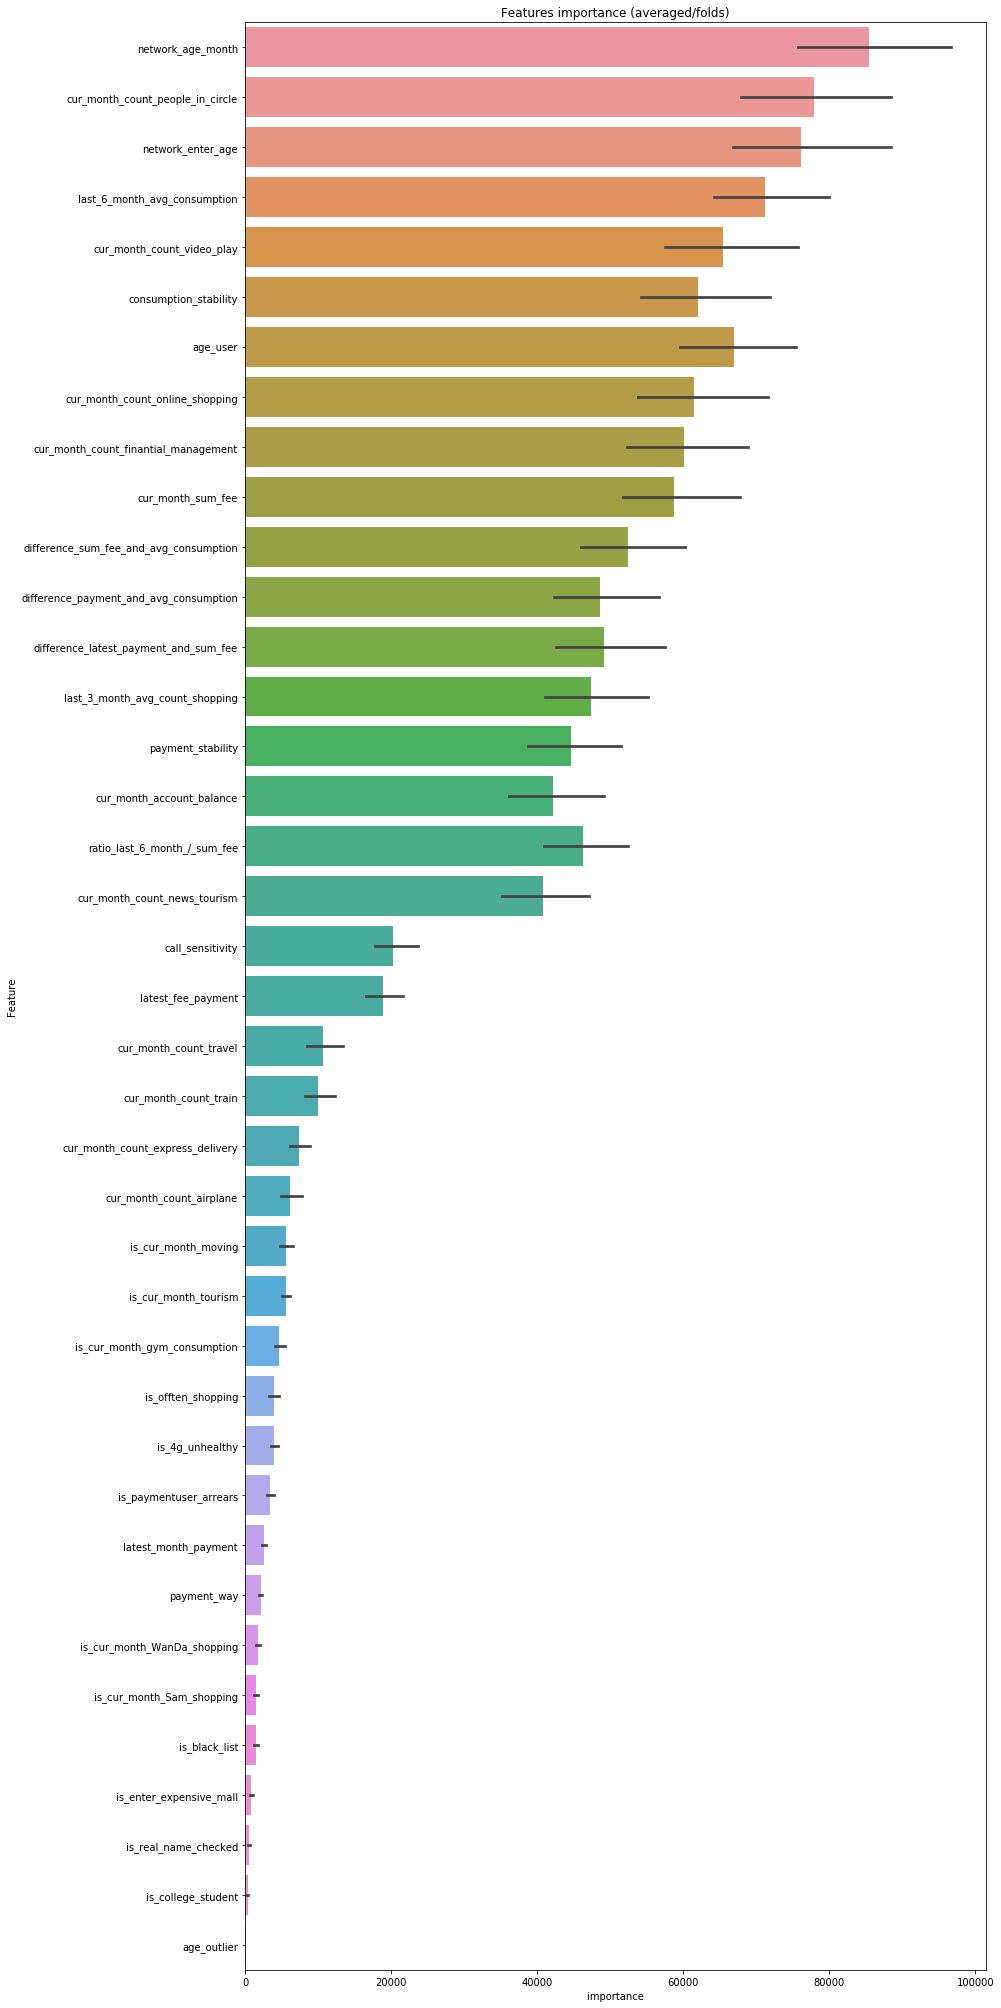

In [61]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig(str(mean_score)+'FI.png')

In [62]:
sub_df = pd.DataFrame({"id":test_df["id"].values})
sub_df["score"] = np.around(mean_predictions).astype(np.int32)
sub_df.to_csv(str(mean_score)+"lgb_leaves:{}_depth:{}_submission.csv".format(params_mse_lgb['num_leaves'], params_mse_lgb['max_depth']), index=False)

In [35]:
train_df['age_user'].describe()

count    50000.000000
mean        38.051640
std         11.268215
min          9.000000
25%         30.000000
50%         36.000000
75%         45.000000
max        111.000000
Name: age_user, dtype: float64

In [51]:
columns = ['apple', 'banana', 'orange']

In [54]:
for column in columns:
    column_name = f'{column}_transform'
    print(column_name)

SyntaxError: invalid syntax (<ipython-input-54-efd94ae12c96>, line 2)